In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Perceptron
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from matplotlib import gridspec
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from mlxtend.plotting import plot_decision_regions
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from ucimlrepo import fetch_ucirepo 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

simplefilter("ignore", category=ConvergenceWarning)

warnings.filterwarnings('ignore')

## Просмотр данных

**Описание файлов данных**

- application_{train|test}.csv
  - Это основная таблица, разделенная на два файла для обучения (с целью — TARGET) и для тестирования (без цели — TARGET).
  - Содержит статические данные для всех заявок. Одна строка представляет один кредит в нашем выборочном наборе данных.

- bureau.csv
  - Все предыдущие кредиты клиента, предоставленные другими финансовыми учреждениями, о которых сообщалось в кредитное бюро (для клиентов, имеющих кредит в нашем наборе).
  - Для каждого кредита в нашей выборке имеется столько строк, сколько кредитов клиент имел в кредитном бюро до даты подачи заявки.

- bureau_balance.csv
  - Ежемесячные балансы предыдущих кредитов в кредитном бюро.
  - Эта таблица содержит одну строку за каждый месяц истории каждого предыдущего кредита, о котором сообщалось в кредитное бюро, — т.е. таблица имеет (#кредитов в выборке * #относительных предыдущих кредитов * #месяцев, в которых у нас есть наблюдаемая история предыдущих кредитов) строк.

- POS_CASH_balance.csv
  - Ежемесячные снимки балансов предыдущих ПВЗ (пунктов выдачи заказов) и наличных кредитов заявителя, взятых в Home Credit.
  - Эта таблица содержит одну строку за каждый месяц истории каждого предыдущего кредита в Home Credit (потребительский кредит и наличные кредиты), связанного с кредитами в нашей выборке — т.е. таблица имеет (#кредитов в выборке * #относительных предыдущих кредитов * #месяцев, в которых у нас есть наблюдаемая история предыдущих кредитов) строк.

- credit_card_balance.csv
  - Ежемесячные снимки балансов предыдущих кредитных карт, которыми владеет заявитель в Home Credit.
  - Эта таблица повторяет структуру для предыдущих кредитов, то есть содержит одну строку за каждый месяц истории каждой предыдущей кредитной карты в Home Credit, связанной с кредитами в нашей выборке.

- previous_application.csv
  - Все предыдущие заявки на кредиты в Home Credit клиентов, имеющих кредиты в нашей выборке.
  - Каждая строка соответствует одной предыдущей заявке, связанной с кредитами в нашем наборе данных.

- installments_payments.csv
  - История погашений по ранее выданным кредитам в Home Credit, связанным с кредитами в нашей выборке.
  - Содержит: а) одну строку за каждый произведенный платеж плюс б) одну строку за каждую пропущенную оплату.
  - Одна строка эквивалентна одному платежу одной доли или одной доли, соответствующей одному платежу одного предыдущего кредита Home Credit, связанного с кредитами в нашей выборке.

- HomeCredit_columns_description.csv
  - Этот файл содержит описания столбцов в различных файлах данных.

In [6]:
application_train = pd.read_csv("/Users/tsarevivan/Downloads/home-credit-default-risk/application_train.csv")
application_train, application_test = train_test_split(application_train, test_size=0.2, random_state=42)

In [7]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
123473,243191,0,Cash loans,F,Y,N,0,171000.0,555273.0,16366.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
10118,111778,0,Cash loans,M,N,Y,1,157500.0,198085.5,23638.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
64716,175057,1,Cash loans,M,Y,Y,0,135000.0,776304.0,25173.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
234940,372147,0,Cash loans,M,Y,Y,1,164133.0,900000.0,36787.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
236051,373412,0,Cash loans,M,N,Y,0,225000.0,533668.5,21294.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0


![image info](./vnyr84vhzozgnfinu2to2tyhlp8.png)

In [9]:
columns_description = pd.read_csv("/Users/tsarevivan/Downloads/home-credit-default-risk/HomeCredit_columns_description.csv")

In [10]:
main_features = columns_description["Row"].head(33)
main_features

0                      SK_ID_CURR
1                          TARGET
2              NAME_CONTRACT_TYPE
3                     CODE_GENDER
4                    FLAG_OWN_CAR
5                 FLAG_OWN_REALTY
6                    CNT_CHILDREN
7                AMT_INCOME_TOTAL
8                      AMT_CREDIT
9                     AMT_ANNUITY
10                AMT_GOODS_PRICE
11                NAME_TYPE_SUITE
12               NAME_INCOME_TYPE
13            NAME_EDUCATION_TYPE
14             NAME_FAMILY_STATUS
15              NAME_HOUSING_TYPE
16     REGION_POPULATION_RELATIVE
17                     DAYS_BIRTH
18                  DAYS_EMPLOYED
19              DAYS_REGISTRATION
20                DAYS_ID_PUBLISH
21                    OWN_CAR_AGE
22                     FLAG_MOBIL
23                 FLAG_EMP_PHONE
24                FLAG_WORK_PHONE
25               FLAG_CONT_MOBILE
26                     FLAG_PHONE
27                     FLAG_EMAIL
28                OCCUPATION_TYPE
29            

In [11]:
categorical_cols = application_train.select_dtypes(include=['object']).columns

# Инициализация LabelEncoder
le = LabelEncoder()

# Кодирование каждого категориального столбца в класс (числовое представление)
for col in categorical_cols:
    application_train[col] = le.fit_transform(application_train[col])
None

In [12]:
categorical_cols_test = application_test.select_dtypes(include=['object']).columns

# Инициализация LabelEncoder
le = LabelEncoder()

# Кодирование каждого категориального столбца в класс (числовое представление)
for col in categorical_cols:
    application_test[col] = le.fit_transform(application_test[col])
None

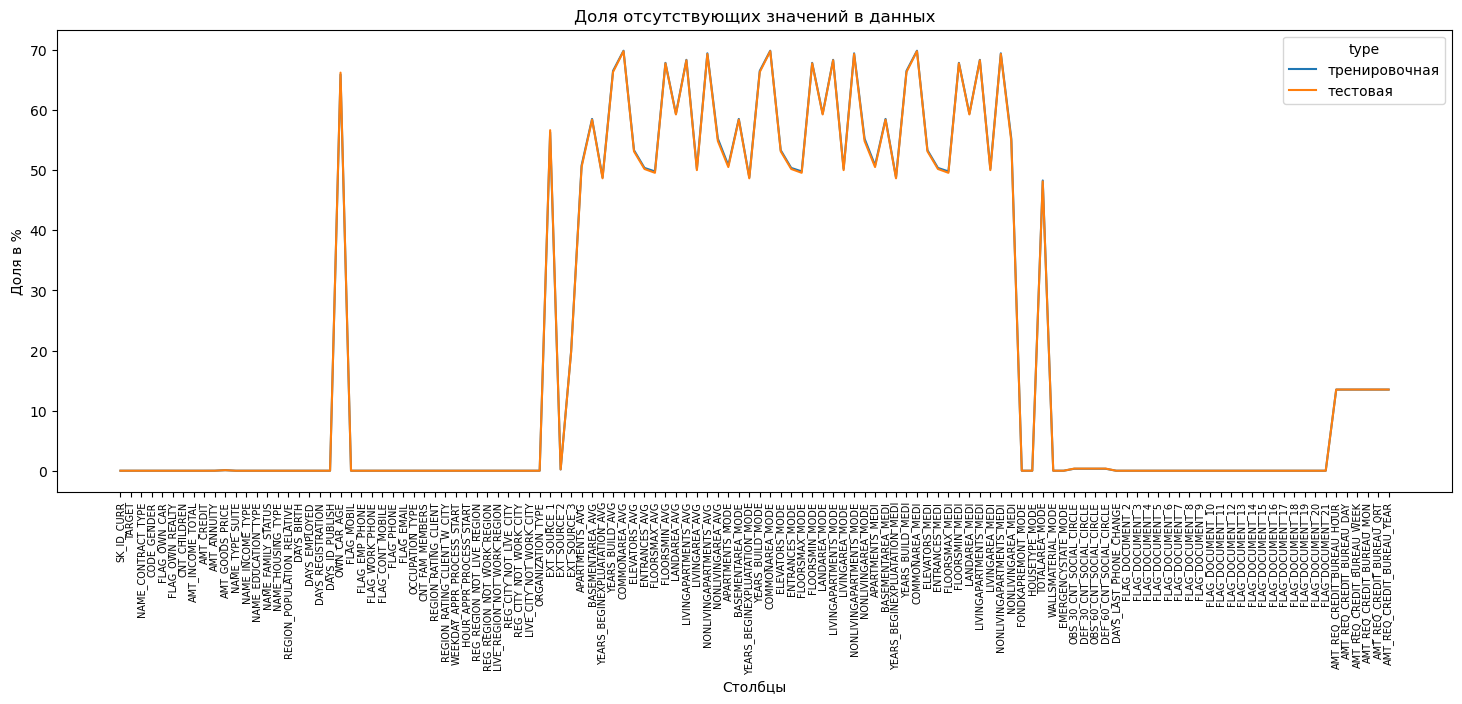

In [13]:
fig = plt.figure(figsize=(18, 6))

miss_train = pd.DataFrame((application_train.isnull().sum()) * 100 / application_train.shape[0]).reset_index()
miss_test = pd.DataFrame((application_test.isnull().sum()) * 100 / application_test.shape[0]).reset_index()

miss_train.columns = ['feature', 'missing_percent']
miss_test.columns = ['feature', 'missing_percent']

miss_train["type"] = "тренировочная"
miss_test["type"] = "тестовая"

missing = pd.concat([miss_train, miss_test], axis=0)

ax = sns.lineplot(x="feature", y="missing_percent", data=missing, hue="type")
plt.xticks(rotation=90, fontsize=7)
plt.title("Доля отсутствующих значений в данных")
plt.ylabel("Доля в %")
plt.xlabel("Столбцы")
None

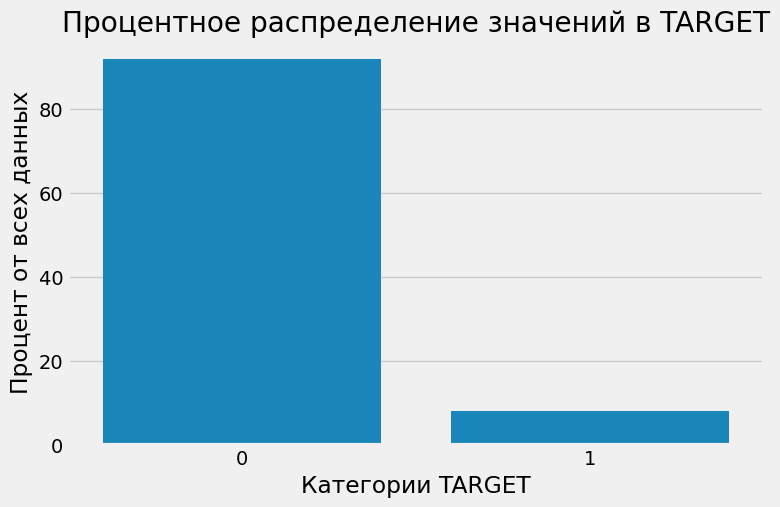

In [14]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [8, 5]


total_count = len(application_train)
value_counts = application_train['TARGET'].value_counts()
percentages = (value_counts / total_count) * 100

ax = sns.barplot(x=percentages.index, y=percentages.values)

plt.title("Процентное распределение значений в TARGET")
plt.ylabel("Процент от всех данных")
plt.xlabel("Категории TARGET")


plt.show()

Итого имеем процент дефолтов:

In [16]:
percentages.values[1]

8.079412051640597

In [17]:
np.abs(application_train.drop(columns=['SK_ID_CURR']).corr()['TARGET']).sort_values(ascending=False).head(30)

TARGET                         1.000000
EXT_SOURCE_3                   0.180096
EXT_SOURCE_2                   0.158824
EXT_SOURCE_1                   0.154135
DAYS_BIRTH                     0.077632
REGION_RATING_CLIENT_W_CITY    0.060598
REGION_RATING_CLIENT           0.058058
CODE_GENDER                    0.054790
DAYS_LAST_PHONE_CHANGE         0.053825
NAME_EDUCATION_TYPE            0.053759
DAYS_ID_PUBLISH                0.052218
REG_CITY_NOT_WORK_CITY         0.051017
FLAG_EMP_PHONE                 0.045673
NAME_INCOME_TYPE               0.044905
DAYS_EMPLOYED                  0.044640
FLAG_DOCUMENT_3                0.044548
REG_CITY_NOT_LIVE_CITY         0.044483
FLOORSMAX_AVG                  0.044281
FLOORSMAX_MEDI                 0.043838
FLOORSMAX_MODE                 0.043344
DAYS_REGISTRATION              0.041712
EMERGENCYSTATE_MODE            0.041426
AMT_GOODS_PRICE                0.040660
HOUSETYPE_MODE                 0.039450
REGION_POPULATION_RELATIVE     0.036909


Во многих столбцах есть пропуски, в модели можно будет их заполнять медианой/средним значением

## Внешние скоры

Видно, что очень сильно коррелируют с таргетом внешние скоры, поэтому посмотрим на них в отдельности:

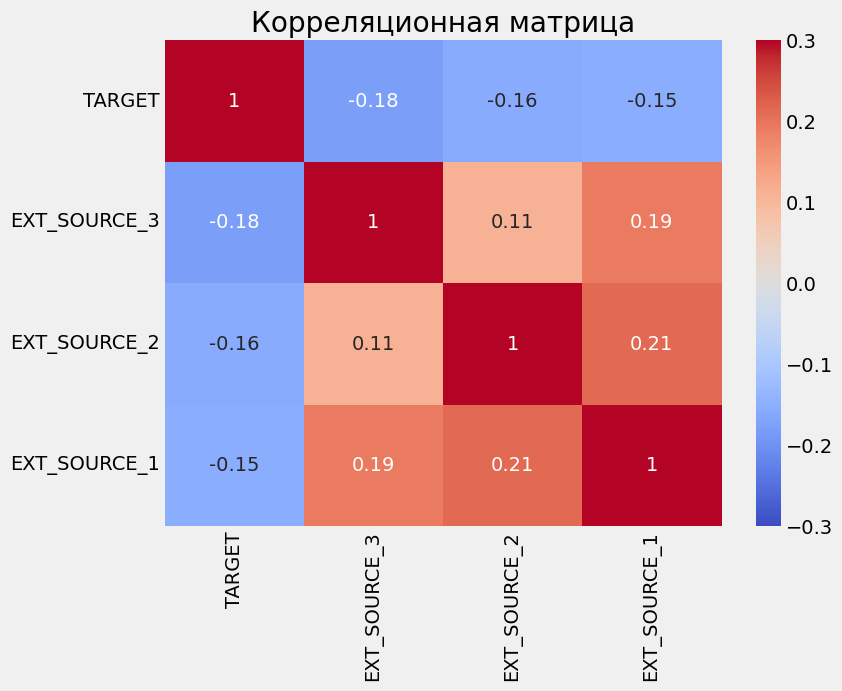

In [21]:
corr_matrix = application_train[["TARGET", "EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin = -0.3, vmax=0.3)
plt.title('Корреляционная матрица')
plt.show()
None

In [22]:
application_train['ext_score_1'] = application_train['EXT_SOURCE_1'].fillna(-1).apply(lambda x: np.round(x, 2))
application_train['ext_score_2'] = application_train['EXT_SOURCE_2'].fillna(-1).apply(lambda x: np.round(x, 2))
application_train['ext_score_3'] = application_train['EXT_SOURCE_3'].fillna(-1).apply(lambda x: np.round(x, 2))

In [23]:
application_train[['ext_score_1', 'ext_score_2', 'ext_score_3']]

,ext_score_1,ext_score_2,ext_score_3
123473,0.52,0.36,0.56
10118,0.24,0.49,0.60
64716,-1.00,0.64,0.71
234940,0.29,0.43,0.51
236051,0.79,0.45,0.53
...,...,...,...
119879,-1.00,0.62,-1.00
259178,0.46,0.72,0.37
131932,0.31,0.61,0.55
146867,0.61,0.60,0.26


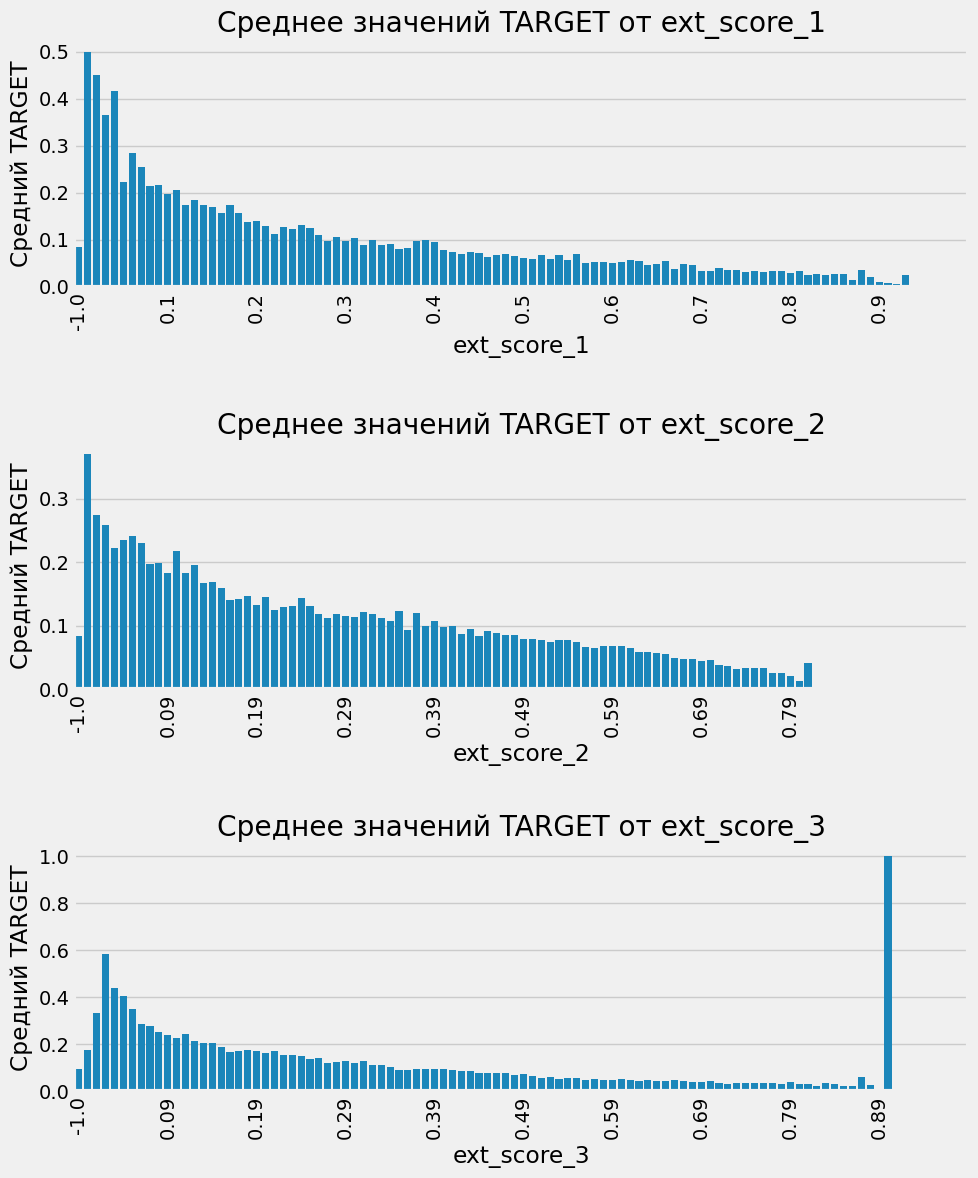

In [24]:
plt.figure(figsize=(10, 12))

for i, source in enumerate(['ext_score_1', 'ext_score_2', 'ext_score_3']):
    plt.subplot(3, 1, i + 1)
    
    mean_target_by_source = application_train.groupby(source)['TARGET'].mean().reset_index()
    sns.barplot(x=source, y='TARGET', data=mean_target_by_source)
    plt.xticks(rotation=90, ticks=np.arange(0, 110, 10))
    plt.title(f'Среднее значений TARGET от {source}')
    plt.xlabel(f'{source}')
    plt.ylabel('Средний TARGET')

plt.tight_layout(h_pad=2.5)
plt.show()

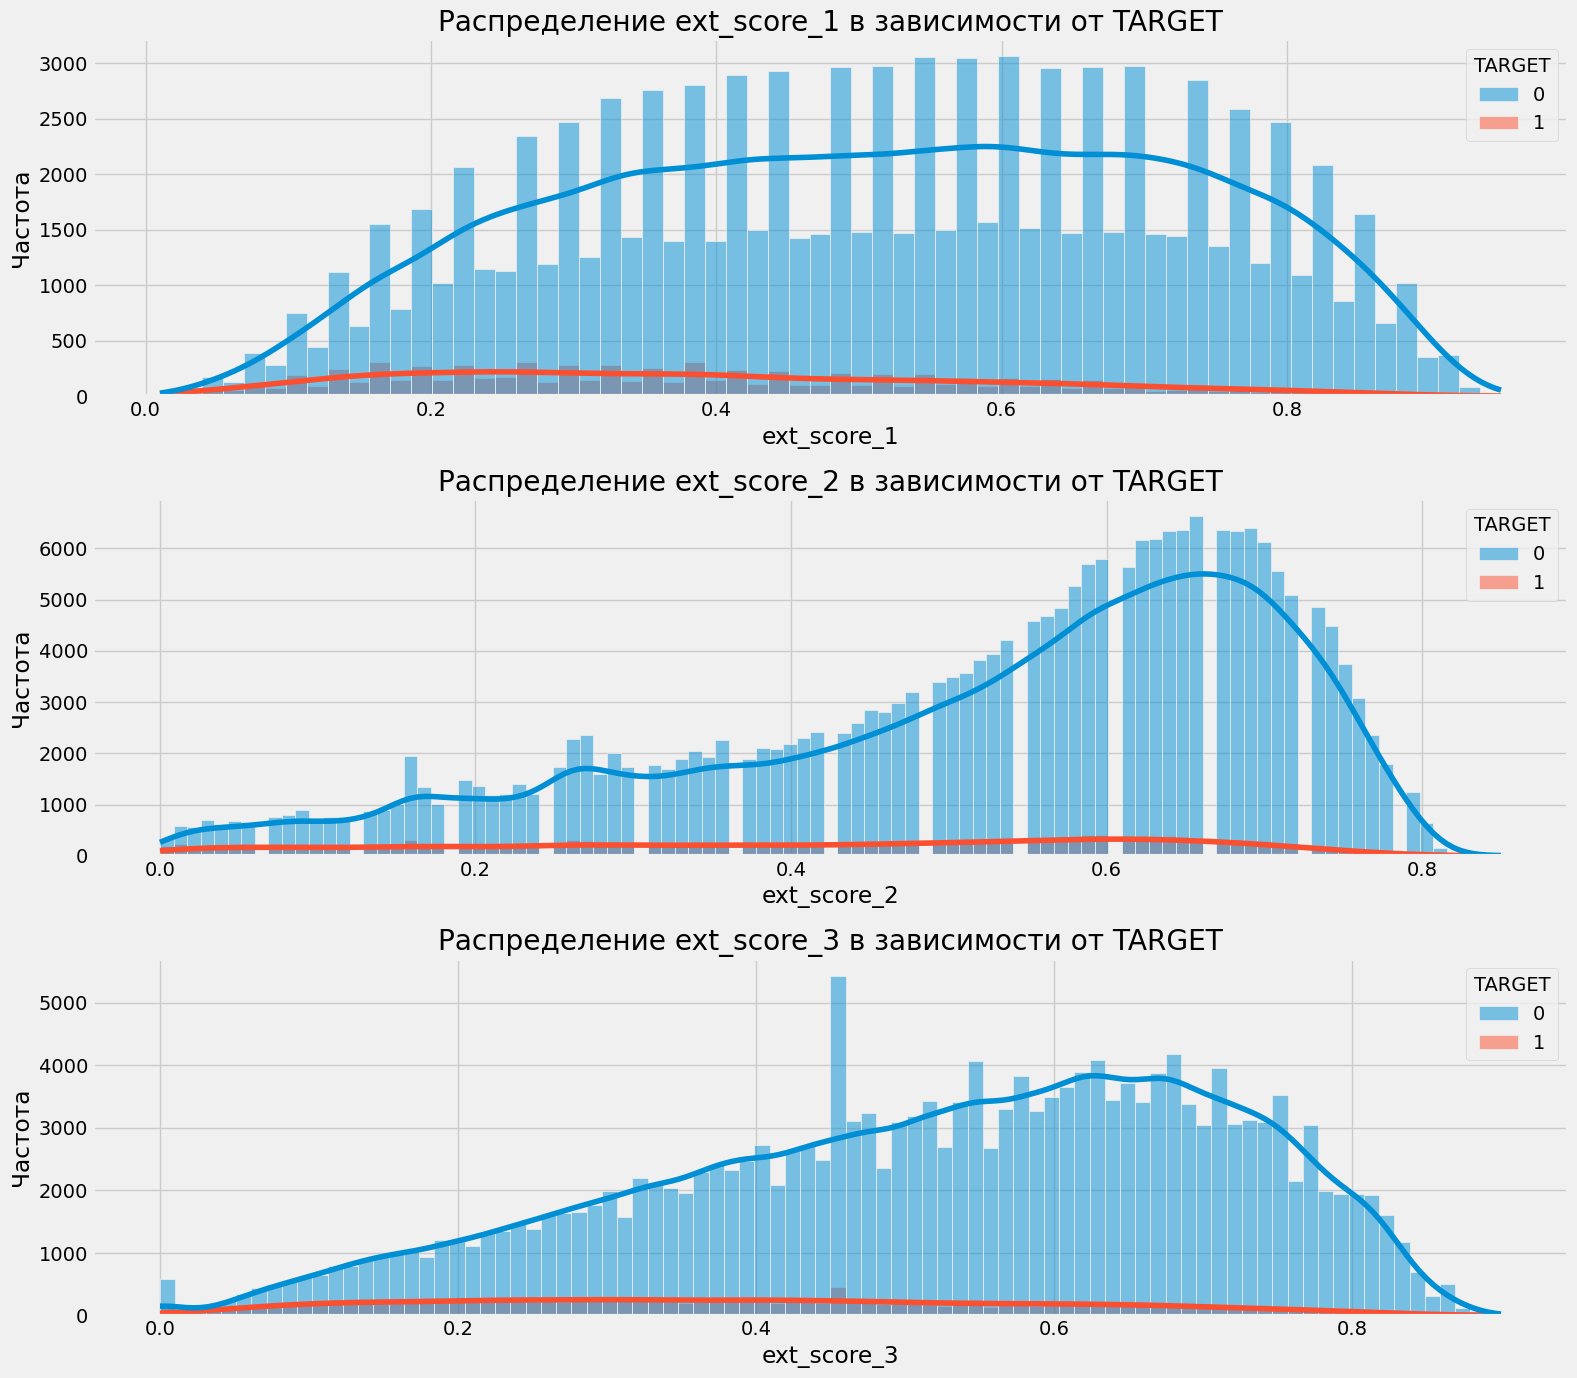

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

for i, feature in enumerate(['ext_score_1', 'ext_score_2', 'ext_score_3']):
    filtered_data = application_train[application_train[feature] >= 0]
    
    sns.histplot(data=filtered_data, x=feature, hue='TARGET', kde=True, ax=axes[i])
    
    axes[i].set_title(f'Распределение {feature} в зависимости от TARGET')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

## Возраст

In [27]:
application_train['client_age'] = np.round(abs(application_train['DAYS_BIRTH']) / 365)

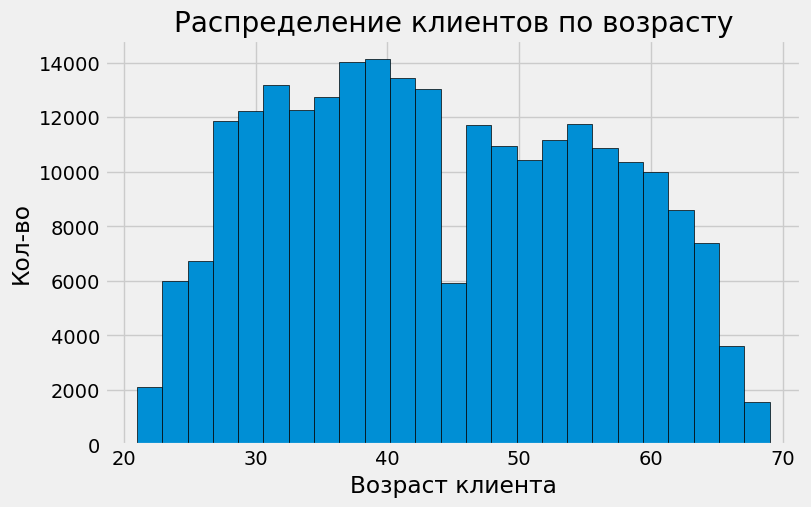

In [28]:
plt.hist(application_train['client_age'], edgecolor = 'k', bins = 25)
plt.title('Распределение клиентов по возрасту'); 
plt.xlabel('Возраст клиента'); 
plt.ylabel('Кол-во');

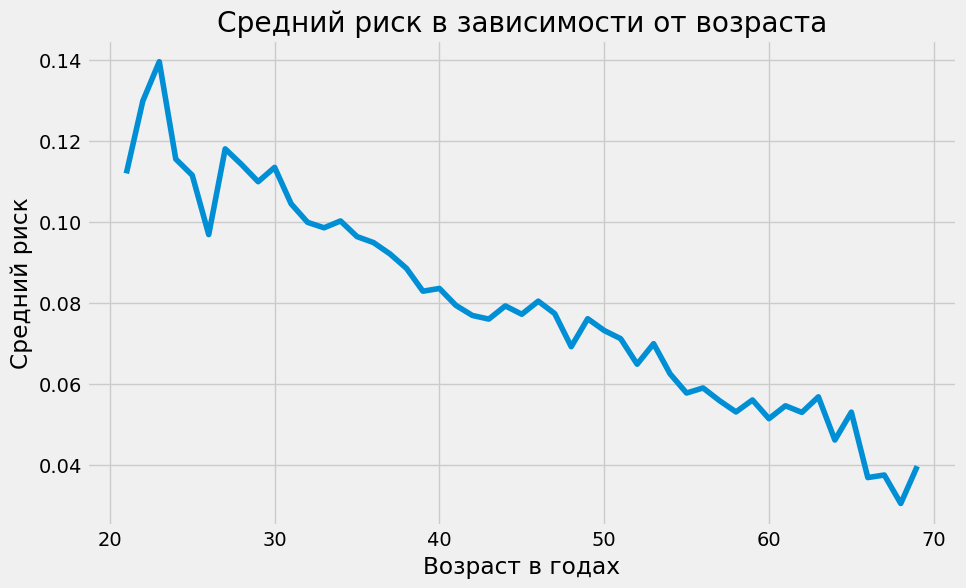

In [29]:
age_target_mean = application_train.groupby('client_age')['TARGET'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=age_target_mean, x='client_age', y='TARGET')

plt.xlabel('Возраст в годах')
plt.ylabel('Средний риск')
plt.title('Средний риск в зависимости от возраста')
plt.show()

## Начинаем применять модели

In [31]:
# Уберем таргет из тренировочных данных
train_labels = application_train['TARGET']
test_labels = application_test['TARGET']
train = application_train.drop(labels=['TARGET', 'ext_score_1', 'ext_score_2', 'ext_score_3', 'client_age'], axis=1)
test = application_test.drop(labels=['TARGET'], axis=1)

# Создадим SimpleImputer для заполнения недостающих значений медианой
imputer = SimpleImputer(strategy='median')

# Создадим MinMaxScaler для нормализации данных
scaler = MinMaxScaler(feature_range=(0, 1))

train_imputed = imputer.fit_transform(train)
train_scaled = scaler.fit_transform(train_imputed)
test_imputed = imputer.fit_transform(test)
test_scaled = scaler.fit_transform(test_imputed)

train_final = pd.DataFrame(train_scaled, columns=train.columns)
test_final = pd.DataFrame(test_scaled, columns=test.columns)

print('Размер тренировочной выборки: ', train_final.shape)
print('Размер тестовой выборки: ', test_final.shape)

Размер тренировочной выборки:  (246008, 121)
Размер тестовой выборки:  (61503, 121)


## Логистическая регрессия

In [33]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(train_final, train_labels)

log_reg_score = log_reg.predict_proba(test_final)[:, 1]
log_reg_predict_target = log_reg.predict(test_final)

In [34]:
logreg_solution = application_test[['SK_ID_CURR', 'TARGET']]
logreg_solution['SCORE'] = log_reg_score
logreg_solution['PREDICT_TARGET'] = log_reg_predict_target

logreg_solution.head()

,SK_ID_CURR,TARGET,SCORE,PREDICT_TARGET
245895,384575,0,0.101186,0
98194,214010,0,0.070547,0
36463,142232,0,0.092070,0
249923,389171,0,0.068793,0
158389,283617,0,0.082610,0


In [35]:
def check_metrics(results_df):
    true_labels = results_df['TARGET']
    predicted_labels = results_df['PREDICT_TARGET']
    predicted_scores = results_df['SCORE']
    
    roc_auc = roc_auc_score(true_labels, predicted_scores)
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    report = classification_report(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    results_df['Rounded_SCORE'] = np.round(results_df['SCORE'], 2)
    mean_target_by_score = results_df.groupby('Rounded_SCORE')['TARGET'].mean()
    count_by_score = results_df.groupby('Rounded_SCORE')['TARGET'].count()
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('score')
    ax1.set_ylabel('Средний риск')
    ax1.plot(mean_target_by_score.index, mean_target_by_score.values, 'o-', color='b', label='Средний риск')
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Кол-во людей')
    ax2.plot(count_by_score.index, count_by_score.values, 'o-', color='r', label='Кол-во людей')
    ax2.tick_params(axis='y')
    
    fig.suptitle('Средний риск и распределение людей по скору')
    ax1.grid(True)
    fig.legend()
    plt.show()

ROC-AUC: 0.6862
Accuracy: 0.9195

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



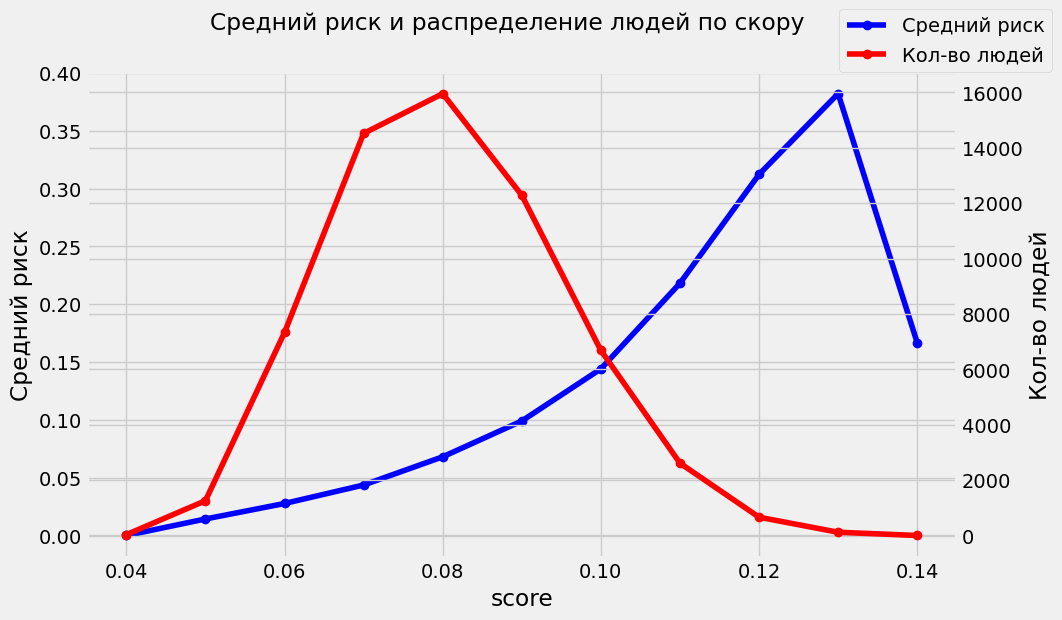

In [36]:
check_metrics(logreg_solution)

## Градиентный бустинг

In [38]:
clf = LGBMClassifier()
clf.fit(train_final, train_labels)

clf_score = clf.predict_proba(test_final)[:, 1]
clf_predict_target = clf.predict(test_final)

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11486
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


In [39]:
clf_solution = application_test[['SK_ID_CURR', 'TARGET']]
clf_solution['SCORE'] = clf_score
clf_solution['PREDICT_TARGET'] = clf_predict_target

clf_solution.head()

,SK_ID_CURR,TARGET,SCORE,PREDICT_TARGET
245895,384575,0,0.144029,0
98194,214010,0,0.037648,0
36463,142232,0,0.128032,0
249923,389171,0,0.020938,0
158389,283617,0,0.095421,0


ROC-AUC: 0.7366
Accuracy: 0.9194

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.47      0.02      0.03      4949

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.50     61503
weighted avg       0.88      0.92      0.88     61503



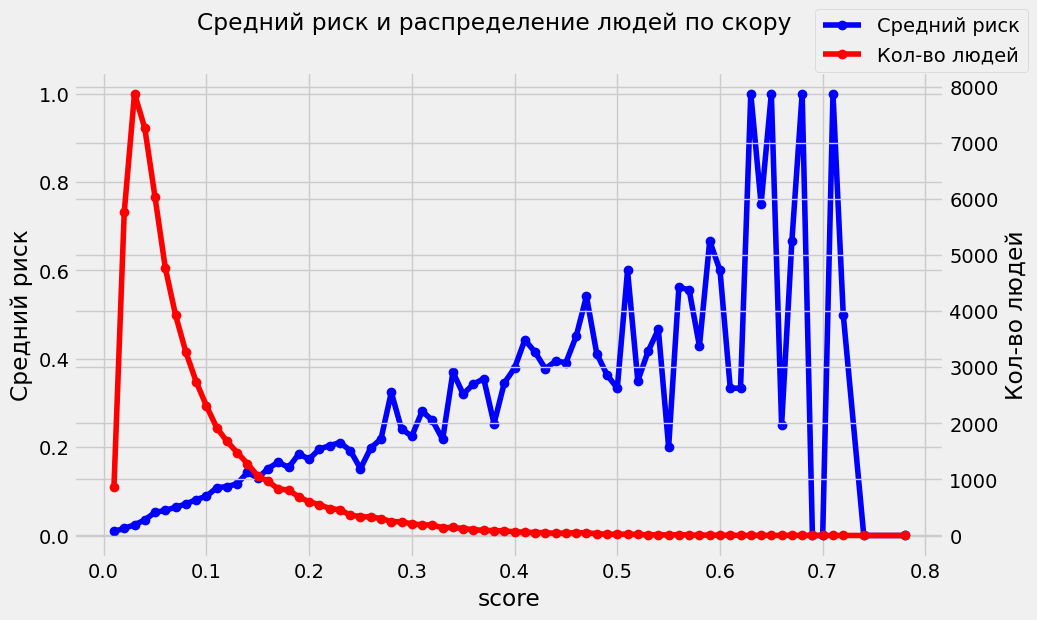

In [40]:
check_metrics(clf_solution)

## CatBoostClassifier

In [42]:
catboost = CatBoostClassifier(
    iterations=1000,      # Количество итераций
    learning_rate=0.05,   # Скорость обучения
    depth=6,              # Глубина дерева
    eval_metric='AUC',    # Метрика оценки
    random_seed=42,
    logging_level='Silent',  # Убираем логирование во время обучения
    early_stopping_rounds=100 # Раннее прекращение в случае стагнации
)
catboost.fit(train_final, train_labels, eval_set=(test_final, application_test['TARGET']))

catboost_score = catboost.predict_proba(test_final)[:, 1]
catboost_predict_target = catboost.predict(test_final)

In [43]:
catboost_solution = application_test[['SK_ID_CURR', 'TARGET']].copy()
catboost_solution['SCORE'] = catboost_score
catboost_solution['PREDICT_TARGET'] = catboost_predict_target

catboost_solution.head()

,SK_ID_CURR,TARGET,SCORE,PREDICT_TARGET
245895,384575,0,0.264807,0
98194,214010,0,0.032788,0
36463,142232,0,0.108675,0
249923,389171,0,0.016964,0
158389,283617,0,0.068905,0


ROC-AUC: 0.7533
Accuracy: 0.9199

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.58      0.02      0.03      4949

    accuracy                           0.92     61503
   macro avg       0.75      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



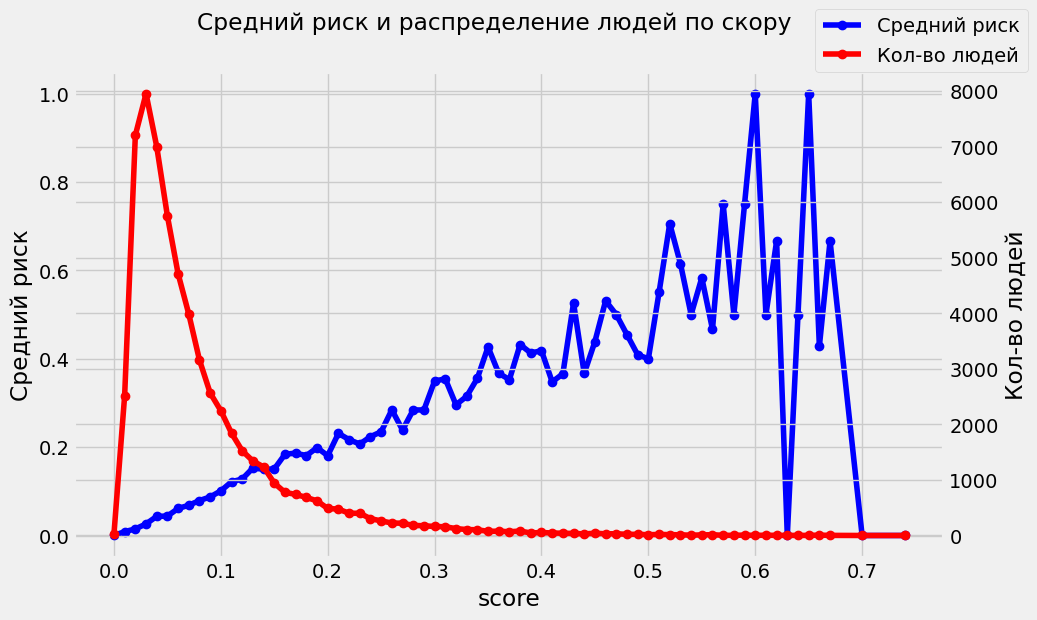

In [44]:
check_metrics(catboost_solution)